In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from numba import njit
import tqdm

plt.style.use(['science', 'grid', 'notebook'])

In [3]:
@njit
def generate_patron(p, N):
    """
    Genera una matriz de datos aleatorios con valores -1 y 1 de manera uniforme.
    
    Parámetros:
    N (int): Número de filas.
    p (int): Número de columnas.
    
    Retorna:
    np.ndarray: Matriz de tamaño (N, p) con valores -1 y 1.
    """
    random_matrix = np.random.uniform(0, 1, (p, N))
    return np.where(random_matrix > 0.5, 1, -1).astype(np.float64)

@njit
def calculate_conections(data):
    """
    Calcula la matriz de conexiones para una matriz de datos.
    
    Parámetros:
    data (np.ndarray): Matriz de datos.
    
    Retorna:
    np.ndarray: Matriz de conexiones.
    """
    # p = data.shape[0]
    N = data.shape[1]
    W = np.ascontiguousarray(np.zeros((N, N), dtype=np.float64))
    data = np.ascontiguousarray(data.T)
    for i in range(N):
        for j in range(N):
            if i != j:
                W[i, j] = np.dot(data[i], data[j])/N
    return W

@njit
def actualize_parallel(W, s):
    return np.sign(np.dot(W, s))

@njit
def actualize_secuential(W, s):
    index = np.arange(s.size)
    np.random.shuffle(index)
    s_new = s.copy()
    for i in index:
        s_new[i] = np.sign(np.dot(W[i], s_new))
    return s_new

@njit
def overlap(s1, s2):
    return np.dot(s1, s2)/s1.size

@njit
def get_steady_point(W, s, max_iter=1000, func=actualize_secuential):
    s_new = func(W, s)
    cont = 0
    while not np.array_equal(s, s_new):
        cont += 1
        s = s_new
        s_new = func(W, s)
        if cont > max_iter:
            break
    return s_new, cont

@njit(parallel=True)
def calculate_overlaps(W, data, func=actualize_secuential):
    overlap_matrix = np.zeros(data.shape[0])
    cont_prom = 0
    for i in range(data.shape[0]):
        steady_point, cont = get_steady_point(W, data[i], func=func)
        overlap_matrix[i] = overlap(data[i], steady_point)
        cont_prom += cont
    return overlap_matrix, cont_prom/data.shape[0]


In [4]:
# defino los N y alphas a utilizar
N = np.array([500, 1000, 2000, 4000])
alpha = np.array([0.12, 0.14, 0.16, 0.18])

## Secuencial

In [5]:
# itero sobre todo los alphas y N
overlap_matrix = np.zeros((len(N), len(alpha)), dtype=np.ndarray)
counter_prom = np.zeros((len(N), len(alpha)), dtype=np.float64)

for i in tqdm.tqdm(range(len(N)), desc='N'):
    for j in range(len(alpha)):
        p = int(N[i]*alpha[j])
        data = generate_patron(p, N[i])
        W = calculate_conections(data)
        overlap_matrix[i, j], counter_prom[i, j] = calculate_overlaps(W, data)

N: 100%|██████████| 4/4 [10:06<00:00, 151.54s/it]


Promedio de iteraciones: [[ 1.23333333  2.11428571  6.7         9.42222222]
 [ 1.53333333  3.32142857 11.79375    24.65555556]
 [ 1.82083333  6.86428571 31.153125   41.43888889]
 [ 2.60208333 13.40892857 58.728125   65.20972222]]


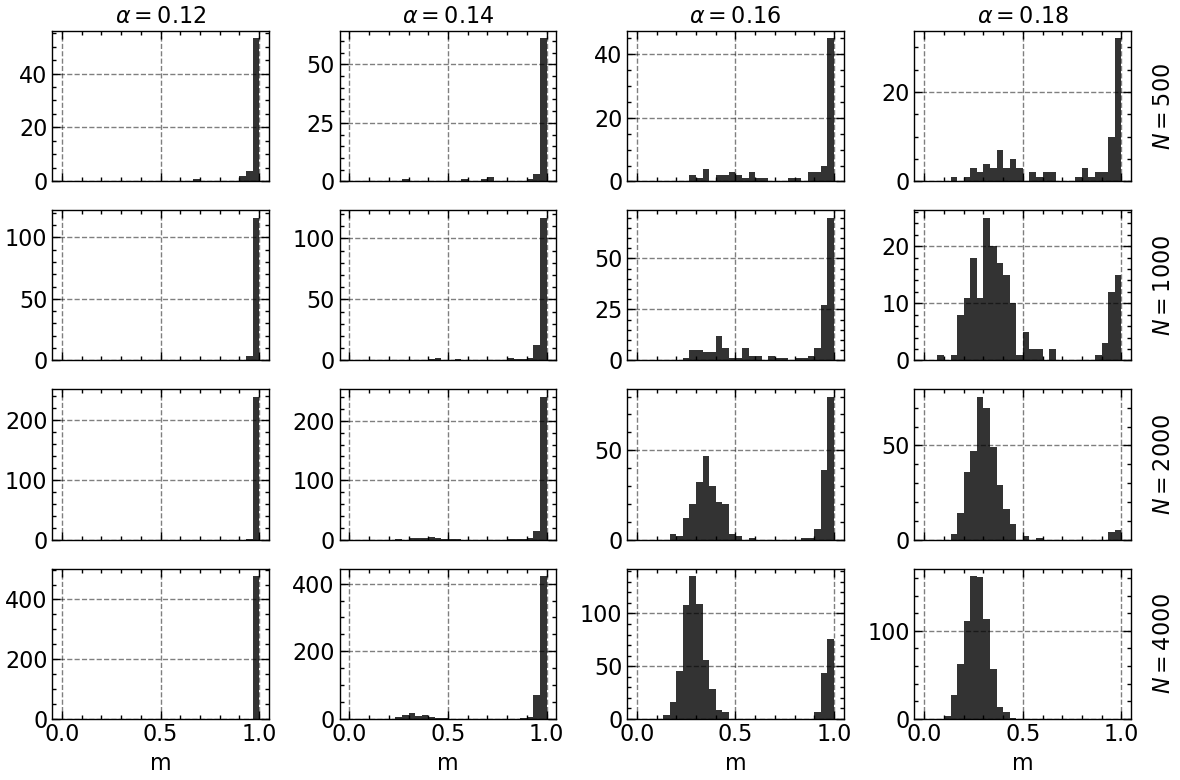

In [47]:
# imprimo los histogramas
print(f'Promedio de iteraciones: {counter_prom}')
fig, axs = plt.subplots(N.size, alpha.size, figsize=(12, 8), sharex=True)

for i in range(N.size):
    for j in range(alpha.size):
        axs[i, j].hist(overlap_matrix[i, j], bins=30, color='black', range=(0,1), alpha=0.8)

        if i == 0:
            axs[i, j].set_title(f'$\\alpha = {alpha[j]}$')
        if j == alpha.size - 1:  # Solo en la última columna de cada fila
            axs[i, j].yaxis.set_label_position("right")  # Coloca el ylabel a la derecha
            axs[i, j].set_ylabel(f'$N = {N[i]}$', labelpad=15)

        if i == N.size - 1:
            axs[i, j].set_xlabel('m')

plt.tight_layout()
plt.savefig('../doc/figures/overlap_histograms.pdf', dpi=500)

## Paralelo

In [7]:
# itero sobre todo los alphas y N
overlap_matrix_parallel = np.zeros((len(N), len(alpha)), dtype=np.ndarray)
counter_prom_parallel = np.zeros((len(N), len(alpha)), dtype=np.float64)

for i in tqdm.tqdm(range(len(N)), desc='N'):
    for j in range(len(alpha)):
        p = int(N[i]*alpha[j])
        data = generate_patron(p, N[i])
        W = calculate_conections(data)
        overlap_matrix_parallel[i, j], counter_prom_parallel[i, j] = calculate_overlaps(W, data, func=actualize_parallel)

N: 100%|██████████| 4/4 [1:15:37<00:00, 1134.34s/it]


Promedio de iteraciones: [[  1.28333333 131.55714286 181.4625     333.88888889]
 [ 76.85       139.68571429 380.34375    623.56111111]
 [ 48.2875     260.64642857 619.99375    761.86388889]
 [109.55833333 454.39464286 856.4        910.41527778]]


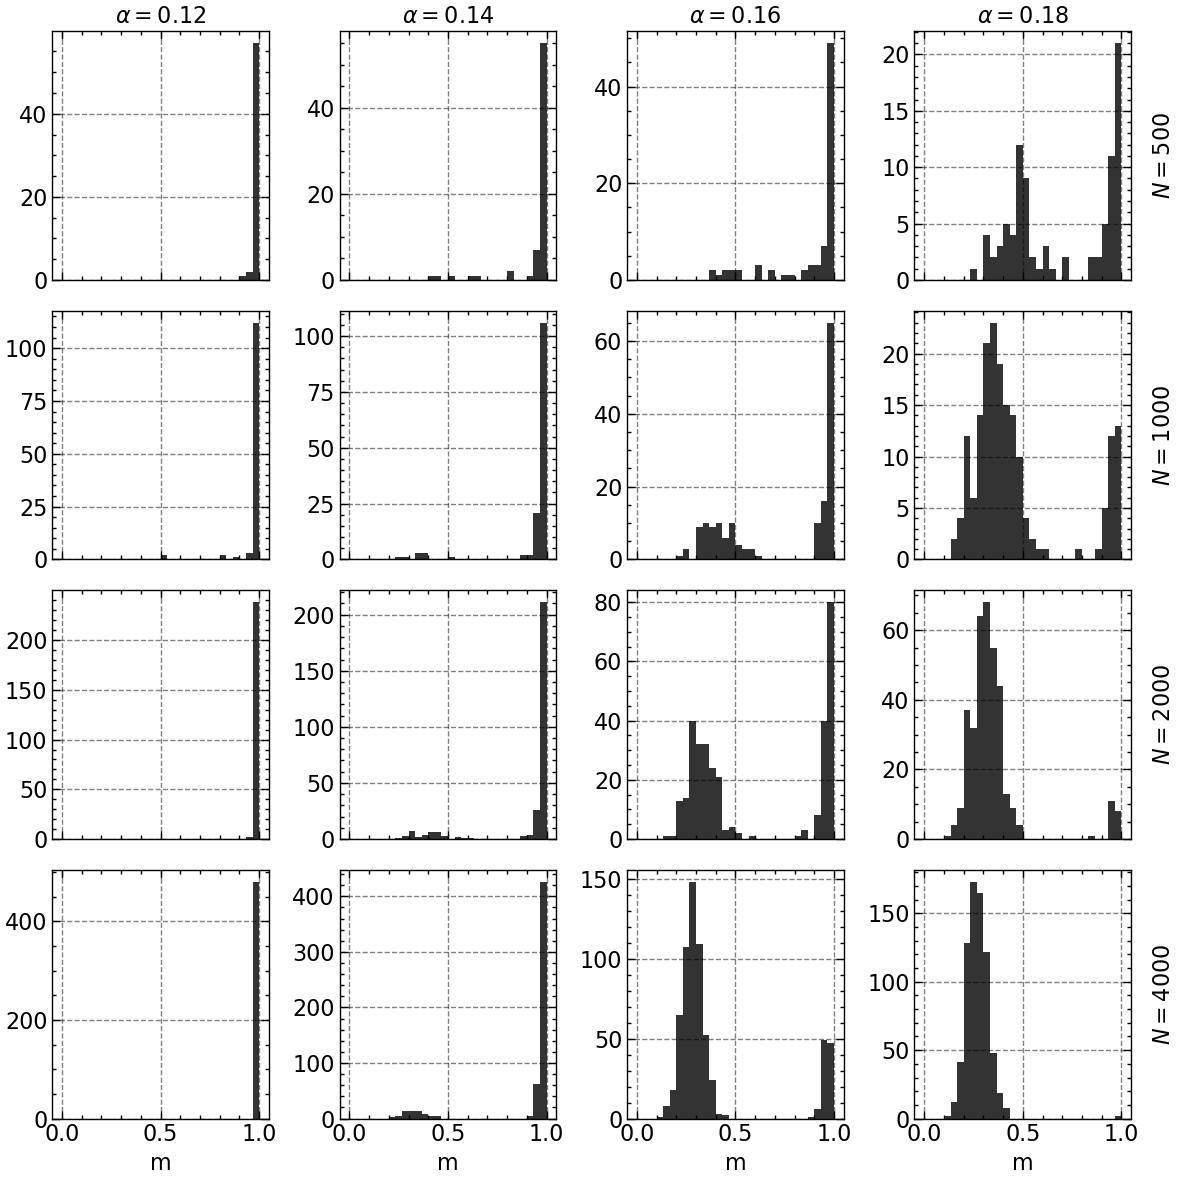

In [8]:
# imprimo los histogramas
print(f'Promedio de iteraciones: {counter_prom_parallel}')
fig, axs = plt.subplots(N.size, alpha.size, figsize=(12, 12), sharex=True)

for i in range(N.size):
    for j in range(alpha.size):
        axs[i, j].hist(overlap_matrix_parallel[i, j], bins=30, color='black', range=(0,1), alpha=0.8)

        if i == 0:
            axs[i, j].set_title(f'$\\alpha = {alpha[j]}$')
        if j == alpha.size - 1:  # Solo en la última columna de cada fila
            axs[i, j].yaxis.set_label_position("right")  # Coloca el ylabel a la derecha
            axs[i, j].set_ylabel(f'$N = {N[i]}$', labelpad=15)

        if i == N.size - 1:
            axs[i, j].set_xlabel('m')

plt.tight_layout()
# plt.savefig('../doc/figures/overlap_histograms.pdf', dpi=500)

Plots de las iteraciones promedios

(4, 4) (4, 4)


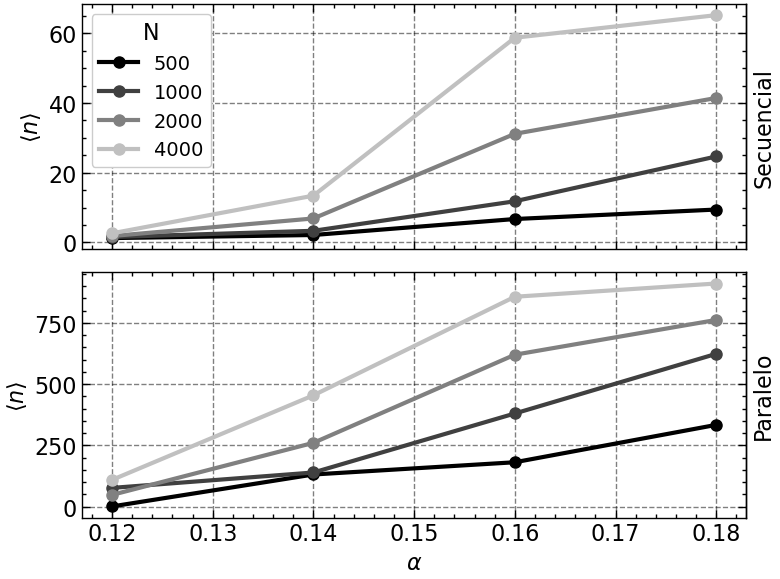

In [43]:
print(counter_prom.shape, counter_prom_parallel.shape)

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

cm = plt.get_cmap('gray')

for i in range(N.size):
    axs[0].plot(alpha, counter_prom[i], '-o', label=f'{N[i]}', color=cm(i/N.size), lw=3, ms=8)
    axs[1].plot(alpha, counter_prom_parallel[i], '-o', label=f'{N[i]}', color=cm(i/N.size), lw=3, ms=8)

axs[0].set_ylabel(r'$\langle n \rangle$')
axs[0].legend(fontsize=14, title='N')
axs[1].set_xlabel('$\\alpha$')
axs[1].set_ylabel(r'$\langle n \rangle$')

# Añadir los títulos adicionales a la derecha y quitar los números
secondary_y0 = axs[0].secondary_yaxis('right')
secondary_y0.set_ylabel('Secuencial', rotation=90)
secondary_y0.set_yticks([])  # Ocultar los números del eje derecho

secondary_y1 = axs[1].secondary_yaxis('right')
secondary_y1.set_ylabel('Paralelo', rotation=90)
secondary_y1.set_yticks([])  # Ocultar los números del eje derecho

# poner secuecial y paralelo del lado derecho del grafico
plt.tight_layout()
plt.savefig('../doc/figures/overlap_vs_alpha.pdf', dpi=500)

